## Постановка задачи: 
    - выгрузка и анализ данных NASA о ближайжих объектах к Земле;
    - применение моделей машинного обучения для выявления опасных астеройдов для Земли;
    - сохраннение обученных моделей;
    - сохранение результатов скориинга на тестовой выборке.

### Этапы:
    1. считать данные и записать в базу данных MySQL;
    2. провести первичный анализ данных;
    3. провести фильтрацию и преобразование данных в случае необходимости;
    4. построить модели машинного обучения. В качестве моделей использовать
        4.1. catboost;
        4.2. pyspark.ml.GBTClassifier;
    5. выбрать лучшую модель на основании отложенной тестовой выборки;
    6. результаты скоринга лучшей модели сохранить в формате parquet и заархивировать; записать в базу данных MySQl;
    7. сохранить лучшую модель.
**Цель:** решить задачу бинарной классификации. В качестве одной из метрик может выступать Recall, так как необходимо выявить максимальную долю объектов положительного класса, потому что цена ошибки второго рода (ложноотрицательное заключение) в данной задаче выше.

In [1]:
import pandas as pd
import numpy as np

from math import ceil

import seaborn as sns
from mysql import connector
import pymysql
from sqlalchemy import create_engine
from matplotlib import pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import roc_auc_score, recall_score, precision_score, confusion_matrix, f1_score, roc_curve

from catboost import CatBoostClassifier

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV



from pyspark.sql import SparkSession
from pyspark.ml.classification import GBTClassifier


import pickle

In [2]:
def connect_and_execute(host='localhost', user='root', password='root', database='nasa_neo', query=None):
    
    """Установка соединения с базой данных и выполнение запроса, который должен быть указан в переменной query.
    """
    

    try:
        with connector.connect(
            host=host,
            user=user,
            password=password,
            database=database
            ) as connection:


            with connection.cursor() as cursor:
                cursor.execute(query)
                
    # in case if database is not created
    except connector.ProgrammingError:
        with connector.connect(
            host=host,
            user=user,
            password=password
            ) as connection:


            with connection.cursor() as cursor:
                cursor.execute(query)

In [3]:
spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext

# 1. Чтение и запись данных

In [4]:
df = pd.read_csv('neo.csv')

In [5]:
# Создание требуемой базы данных в случае ее отсутсвия
create_db = 'CREATE DATABASE IF NOT EXISTS nasa_neo'
connect_and_execute(query=create_db)

In [6]:
# запись таблицы neo.csv в базу данных nasa_neo
username = 'root'
password = 'root'
host = 'localhost'
database = 'nasa_neo'

engine = create_engine(f"mysql+pymysql://{username}:{password}@{host}/{database}")

df.to_sql('nasa', con=engine, if_exists='replace', index = False)

# 2. EDA

**Цель**: изучение природы и состава данных, анализ аномалий (выбросов), ошибок в данных, пропущенных значений.

In [7]:
df.head()

,id,name,est_diameter_min,est_diameter_max,relative_velocity,miss_distance,orbiting_body,sentry_object,absolute_magnitude,hazardous
0,2162635,162635 (2000 SS164),1.198271,2.679415,13569.249224,5.483974e+07,Earth,False,16.73,False
1,2277475,277475 (2005 WK4),0.265800,0.594347,73588.726663,6.143813e+07,Earth,False,20.00,True
2,2512244,512244 (2015 YE18),0.722030,1.614507,114258.692129,4.979872e+07,Earth,False,17.83,False
3,3596030,(2012 BV13),0.096506,0.215794,24764.303138,2.543497e+07,Earth,False,22.20,False
4,3667127,(2014 GE35),0.255009,0.570217,42737.733765,4.627557e+07,Earth,False,20.09,True


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90836 entries, 0 to 90835
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  90836 non-null  int64  
 1   name                90836 non-null  object 
 2   est_diameter_min    90836 non-null  float64
 3   est_diameter_max    90836 non-null  float64
 4   relative_velocity   90836 non-null  float64
 5   miss_distance       90836 non-null  float64
 6   orbiting_body       90836 non-null  object 
 7   sentry_object       90836 non-null  bool   
 8   absolute_magnitude  90836 non-null  float64
 9   hazardous           90836 non-null  bool   
dtypes: bool(2), float64(5), int64(1), object(2)
memory usage: 5.7+ MB


In [9]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
id,90836.0,1.438288e+07,2.087202e+07,2.000433e+06,3.448110e+06,3.748362e+06,3.884023e+06,5.427591e+07
est_diameter_min,90836.0,1.274321e-01,2.985112e-01,6.089126e-04,1.925551e-02,4.836765e-02,1.434019e-01,3.789265e+01
est_diameter_max,90836.0,2.849469e-01,6.674914e-01,1.361570e-03,4.305662e-02,1.081534e-01,3.206564e-01,8.473054e+01
relative_velocity,90836.0,4.806692e+04,2.529330e+04,2.033464e+02,2.861902e+04,4.419012e+04,6.292360e+04,2.369901e+05
miss_distance,90836.0,3.706655e+07,2.235204e+07,6.745533e+03,1.721082e+07,3.784658e+07,5.654900e+07,7.479865e+07
absolute_magnitude,90836.0,2.352710e+01,2.894086e+00,9.230000e+00,2.134000e+01,2.370000e+01,2.570000e+01,3.320000e+01


In [10]:
print('Подсчет пропущенных значений')
df.isnull().sum()

Подсчет пропущенных значений


id                    0
name                  0
est_diameter_min      0
est_diameter_max      0
relative_velocity     0
miss_distance         0
orbiting_body         0
sentry_object         0
absolute_magnitude    0
hazardous             0
dtype: int64

In [11]:
df.nunique()

id                    27423
name                  27423
est_diameter_min       1638
est_diameter_max       1638
relative_velocity     90828
miss_distance         90536
orbiting_body             1
sentry_object             1
absolute_magnitude     1638
hazardous                 2
dtype: int64

В данных присутсвует 27423 уникальных объекта. Визуализируем, какие параметры изменяются среди набоюдений для уникального объекта. 

<AxesSubplot:>

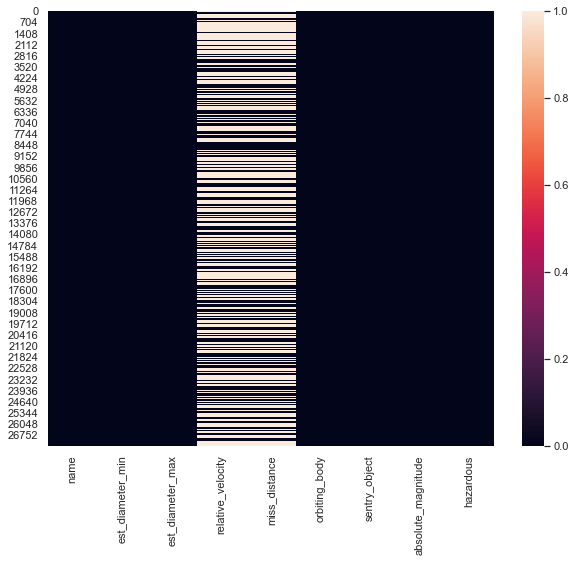

In [12]:
# count unique values of every asteroid
grouped_by_id = df.groupby(['id'], as_index=False).nunique()


sns.set(rc={'figure.figsize': (10, 8)})
sns.heatmap(grouped_by_id.drop(columns=['id']) > 1)

**Промежуточные выводы:**
* пропущенные значения отсутствуют;
* количество уникальных идентификаторов (id) и названий астеройдов (name) совпадают. Таким образом, подтверждается, что каждому астеройду соответсвует свой идентификатор;
* Различные наблюдения одного объекта отличаются только по параметрам `relative_velocity`, `miss_distance`. В случае наличия признака *Observation Date*-даты наблюдения, степень изменчивости этих параметров могла бы быть использована в качестве дополнительного признака;
* признаки `orbiting_body` и `sentry_object` имеют одно уникальное значение, поэтому эти признаки в дальнейшем можно не рассматривать;
* совпадает количество уникальных значений параметров `est_diameter_min` и `est_diameter_max`. Можно предположит, что они зависимы дург от друга. Для подтверждения этого предположения может быть расчитан коэффициент корреляции и для визуализации построен график зависимости одного признака от другого.


<AxesSubplot:xlabel='est_diameter_min', ylabel='est_diameter_max'>

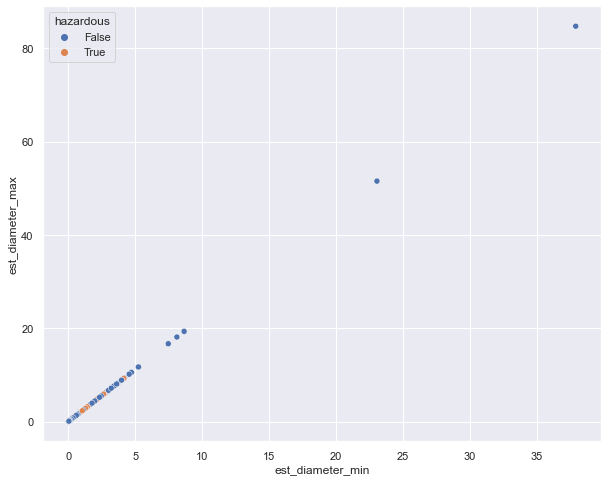

In [13]:
# Коэффициент коррелиции признаков est_diameter_min и est_diameter_max
sns.scatterplot(x='est_diameter_min', y='est_diameter_max', data=df, hue='hazardous')

In [14]:
np.corrcoef(df['est_diameter_min'], df['est_diameter_max'])

array([[1., 1.],
       [1., 1.]])

**Вывод:** признаки `est_diameter_min` и `est_diameter_max` линейно зависимы. Коэффициент корреляции равен 1. Таким образом, эти признаки дублируют друг друга, поэтому от одного из них можно избавиться. Либо можно эти два признака заменить одним дургим. est_diameter_min, est_diameter_max  - минимальный и максимальный наблюдаемые диаметры астеройда. Можно создать признак mean_diameter = (est_diameter_max + est_diameter_min) / 2, который будет характеризовать средний радиус астеройда.

Будут удалены или заменены следующие признаки:
* **УДАЛЕН:** `name` , так как этот признак дурблирует;
* **УДАЛЕНЫ:** `orbiting_body` и `sentry_object`, так как эти признаки имеют только одно значение. Следовательно они не могут быть использованы для разделения на два класса;
* **ЗАМЕНЕНЫ:** `est_diameter_max`, `est_diameter_min` на *`mean_diameter`* = (est_diameter_max + est_diameter_min) / 2.

### Рассмотрим распределение оставшихся признаков

In [15]:
columns_to_drop = ['name', 'est_diameter_min', 'est_diameter_max', 'orbiting_body', 'sentry_object']


df_dropped_features = df.drop(columns=columns_to_drop)
df_dropped_features['mean_diameter'] = (df['est_diameter_max'] + df['est_diameter_min']) / 2


# выделим непрерывные переменные для их дальнейшего изучения
# типу int64 соответсвует id. Изучение распределния данного признака не требуется
float_features = df_dropped_features.select_dtypes(include='float64').columns.tolist()

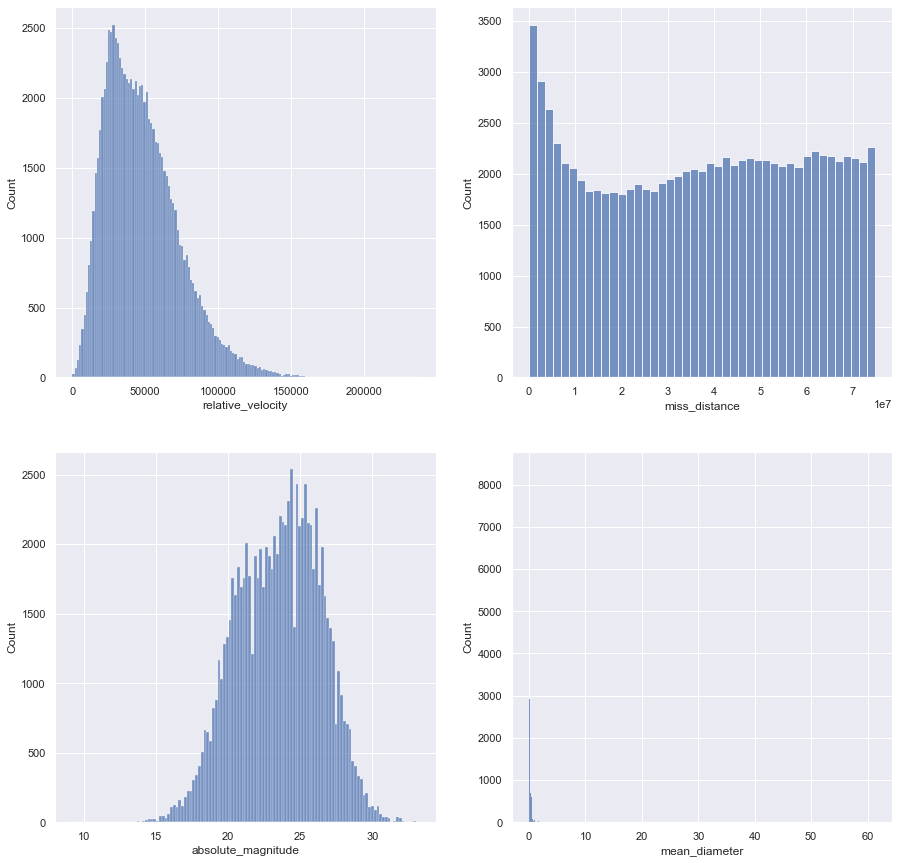

In [16]:
fig, axs = plt.subplots(ceil(len(float_features) / 2), 2, figsize=(15, 15))
for i, float_column in enumerate(float_features):
    sns.histplot(data=df_dropped_features, x=float_column, ax=axs[i//2, i%2])

Рассмотрим детальнее график распределение признака `mean_diameter`.

(0.0, 10.0)

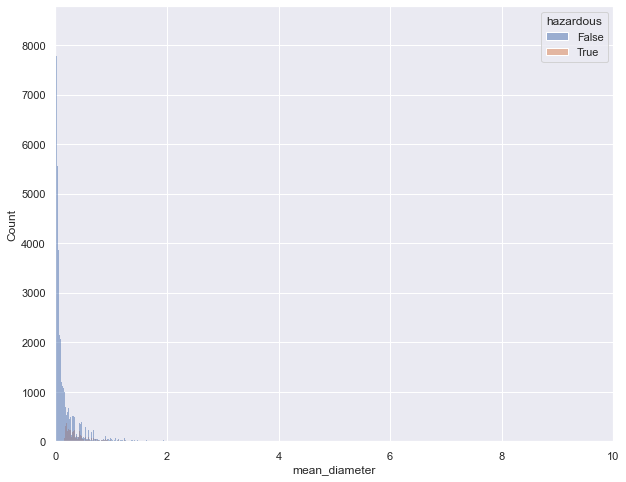

In [17]:
sns.histplot(data=df_dropped_features, x='mean_diameter', hue='hazardous')
plt.xlim([0, 10])

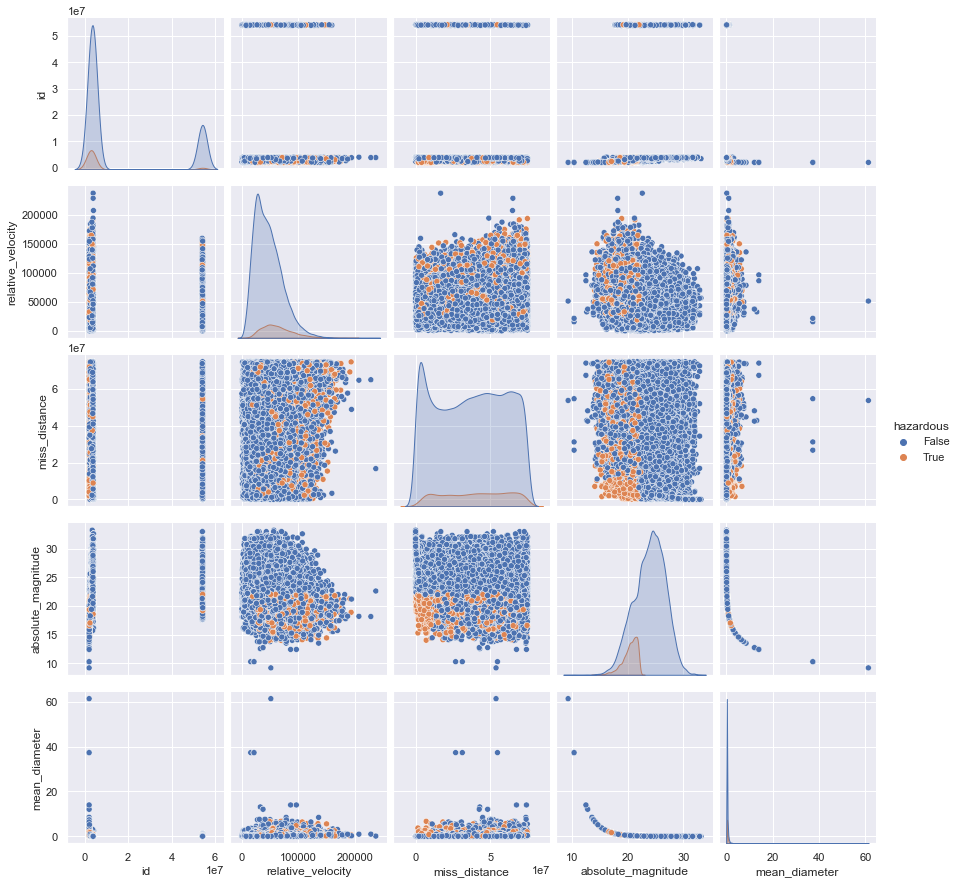

In [18]:
sns.pairplot(data=df_dropped_features, hue='hazardous')

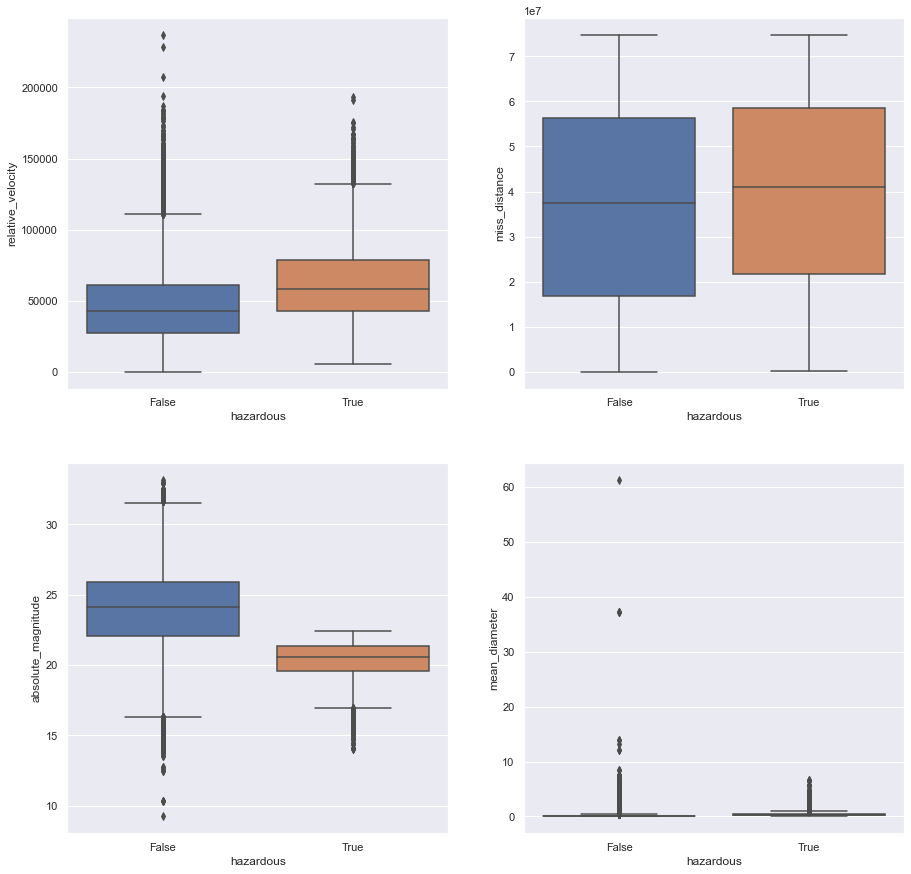

In [19]:
fig, axs = plt.subplots(ceil(len(float_features) / 2), 2, figsize=(15, 15))
for i, float_column in enumerate(float_features):
    sns.boxplot(data=df_dropped_features, x='hazardous', y=float_column, ax=axs[i//2, i%2])

### Распределение целевой переменной

<AxesSubplot:xlabel='hazardous', ylabel='count'>

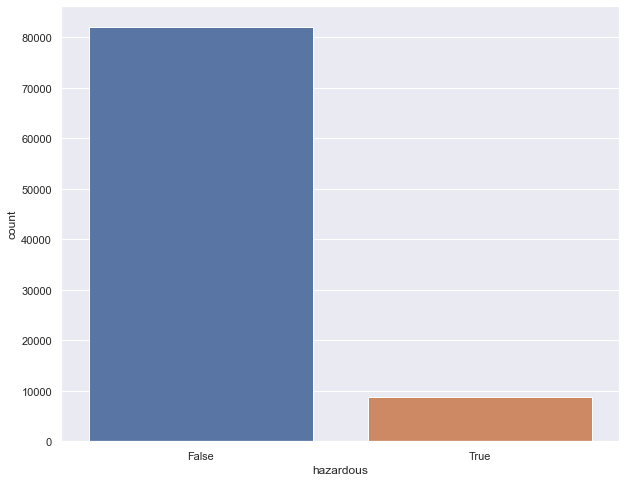

In [20]:
sns.countplot(data=df_dropped_features, x='hazardous')

**Выводы:**
* в текущей версии данных присутсвует 4 непрерывных переменных;
* две переменные имеют распределение близкое к нормальному: `relative_velocity`, `absolute_magnitude`;
* переменная `miss_distance` имеет распределение близкое к равномерному;
* распределение признака  `absolute_magnitude` отличается в зависимости от целевой переменной;
* во всех признаках кроме `miss_distance` присутствуют выбросы;
* т.к. рассматриваемые модели в данной задаче - вариации градиентного бустинга, то в первом приближении фильтрация данных от выбросов и преобразование данных не требуется, так как градиантный бустинг устойчив к выбросам и не требователен к типу распределения;
* дисбаланс целевой переменной. Для оценки качетсва модели следует применять стратификацию по целевой переменной, а также метрики, устойчивые к дисбалансу: ROC-AUC, F1_score, Recall, Precision.

## Создание дополнительных признаков

В качестве нового признака создадим категории, которые классифицируют астероиды по размерам. Возьмем логарифмическую последовательность размеров, т.е. 10, 100, 1000 и т.д. Такой подход выбран из соображения, что количество астероидов от их размеров имеет логарифмическое распределение.

In [21]:
log_scaled_diam = np.logspace(2, 5, num=15) / 1000
log_scaled_diam = np.concatenate([[0], log_scaled_diam]).tolist()  # добавил в начало списка значение 0



# составим список из интервалов между двумя диаметрами
# интервал предсавляет из себя кортеж, который включает в себя два соседник диаметра. Кортежи применяется для того, чтобы была
# возможность использовать интервал в качестве ключа словаря
log_scaled_diam = [tuple(log_scaled_diam[i: i + 2]) for i in range(len(log_scaled_diam) - 1)]

size_categoty = list(range(len(log_scaled_diam)))


SIZE_CATEGORY_DICT = { key: value for key, value in zip(log_scaled_diam, size_categoty)}

In [22]:
def get_size_category(mean_diameter):
    
    for key, value in SIZE_CATEGORY_DICT.items():
        if key[0] <= mean_diameter <= key[1]:
            return value

In [23]:
df_dropped_features['size_category'] = df_dropped_features['mean_diameter'].apply(get_size_category).astype(object)

Следующие признаки создавались, основываясь на интуиции, что сумма и произведение признаков отличается в зависимости от класса

In [24]:
df_dropped_features['sum_feature'] = df_dropped_features[['absolute_magnitude', 'mean_diameter', 'size_category']].sum(axis=1)
df_dropped_features['prod_feature'] = df_dropped_features[['absolute_magnitude', 'mean_diameter', 'size_category']].apply(np.prod, axis=1)

<AxesSubplot:xlabel='size_category', ylabel='count'>

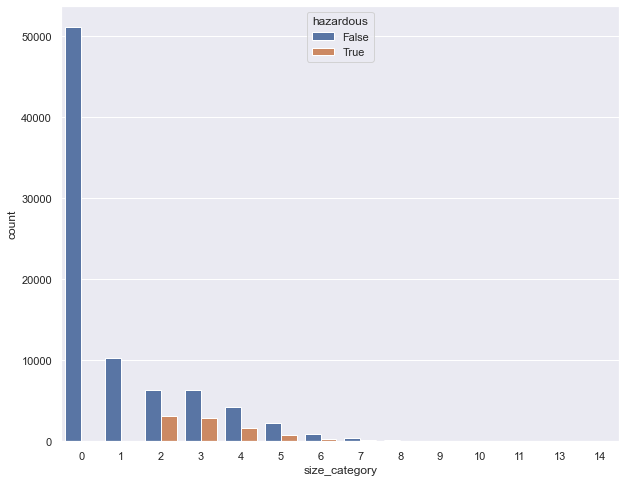

In [25]:
sns.countplot(data=df_dropped_features, x='size_category', hue='hazardous')

Промежуточные выводы:
* распределение соответсnвует логарифмическому. Основная часть опасных астероидов имеет категорию 2 и выше.

# 3. Разбиение данных на обучающую и тестовую выборки

In [26]:
RANDOM_STATE = 123

In [27]:
X_train, X_test, y_train, y_test = train_test_split(df_dropped_features.drop(columns=['id', 'hazardous']), 
                                                    df_dropped_features['hazardous'].astype(int),
                                                   test_size=0.25,
                                                   stratify=df_dropped_features['hazardous'].astype(int),
                                                   random_state=RANDOM_STATE)

In [28]:
TRAIN = pd.concat([X_train, y_train], axis=1)
TEST = pd.concat([X_train, y_train], axis=1)

TRAIN.to_csv('train.csv')
TEST.to_csv('test.csv')

# 4. Построение моделей

## CatBoostClassifier

In [29]:
cb_clf = CatBoostClassifier(max_depth=5, 
                            auto_class_weights='Balanced', 
                            verbose=False, 
                            cat_features=['size_category'],
                           random_state=RANDOM_STATE)

# params = {'learning_rate':[0.05, 0.1],
#       'max_depth':[3, 5, 7]}


# grid_clf = GridSearchCV(cb_clf, params, scoring='roc_auc', n_jobs=-1, cv=5)
# grid_clf.fit(X_train, y_train)

# best_clf = grid_clf.best_estimator_

In [30]:
cb_clf.fit(X_train, y_train)
pred_proba = cb_clf.predict_proba(X_test)

In [31]:
print('CatBoostClassifier')
print(f'ROC_AUC: {roc_auc_score(y_test, pred_proba[:, 1])}')
print(f'RECAL: {recall_score(y_test, pred_proba[:, 1] > 0.25)}')
print(f'PRECISION: {precision_score(y_test, pred_proba[:, 1] > 0.25)}')

CatBoostClassifier
ROC_AUC: 0.9312311669987654
RECAL: 0.9923076923076923
PRECISION: 0.30753050063104753


In [32]:
confusion_matrix(y_test, pred_proba[:, 1] > 0.5)

array([[16124,  4375],
       [   58,  2152]], dtype=int64)

Text(0, 0.5, 'True positive rate')

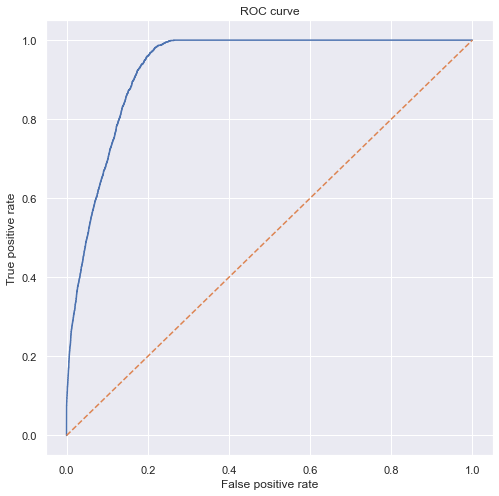

In [33]:
fpr, tpr, threshoulds = roc_curve(y_test, pred_proba[:, 1])

plt.subplots(1, figsize=(8, 8))
plt.title('ROC curve')
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], ls='--')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')

## PySpark GBTClassifier

In [34]:
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.feature import OneHotEncoder, VectorAssembler
from pyspark.sql.functions import col

In [35]:
# запишем данные полученные в ходе первичной обработки
train_data = spark.read.csv("train.csv", header="true", inferSchema="true")
train_data = train_data.withColumn("hazardous", col('hazardous').cast('int'))

test_data = spark.read.csv("test.csv", header="true", inferSchema="true")
test_data = train_data.withColumn("hazardous", col('hazardous').cast('int'))

In [36]:
test_data

DataFrame[_c0: int, relative_velocity: double, miss_distance: double, absolute_magnitude: double, mean_diameter: double, size_category: int, sum_feature: double, prod_feature: double, hazardous: int]

In [37]:
# выделим признаки, которые не учавствуют в обучении моедли
ingore_columns = ['_c0', 'hazardous', 'size_category']

In [38]:
def data_encoding(data, ingore_columns, one_hot_enc_col='size_category'):
    """Кодирование категориальной переменной. Подготовка выборки для подачи в модель."""
    encoder = OneHotEncoder(dropLast=False, inputCol=one_hot_enc_col, outputCol=one_hot_enc_col + '_vec')
    encoded = encoder.fit(data).transform(data)
    
    ignore = ingore_columns
    assembler = VectorAssembler(
        inputCols=[x for x in encoded.columns if x not in ignore],
        outputCol='features')

    encoded = assembler.transform(encoded).select("hazardous", "features")
    
    return encoded

In [39]:
# Получение обучающей и тестовой выборки для подачи в модель
train = data_encoding(train_data, ingore_columns)
test = data_encoding(test_data, ingore_columns)

In [40]:
gbt = GBTClassifier(labelCol="hazardous",
                    featuresCol="features", maxIter=100, maxDepth=5, seed=RANDOM_STATE)
model = gbt.fit(train)

In [41]:
predictions = model.transform(test)

In [42]:
evaluator = BinaryClassificationEvaluator(
                                         labelCol="hazardous",
                                         rawPredictionCol="probability", 
                                         metricName="areaUnderROC")

In [43]:
print('PySpark GBTClassifier')
print(f'ROC_AUC: {evaluator.evaluate(predictions)}')

PySpark GBTClassifier
ROC_AUC: 0.9256043097272081


# 5. Сохранение результатов 

Качество двух моделей приблизительно одинаково, но CatBoost незначительно лучше, поэтому сохраним результаты работы CatBoostClassifier. Сохраним результаты скоринга тестовой выборки, а также саму модель.

In [44]:
X_test_save = X_test.copy()
X_test_save['pred_proba'] = pred_proba[:, 1]

# сохранение в базу данных MySQL
X_test_save.to_sql('nasa_test_sample', con=engine, if_exists='replace', index = False)

# сохранение в формате parquet
X_test_save.to_parquet('X_test_save.parquet.gzip',
              compression='gzip')

In [45]:
filename = 'cat_boost_model.pickle'
pickle.dump(cb_clf, open(filename, 'wb'))

# Результаты и выводы
    - был проведен первичный анализ данных (EDA);
    - на основе EDA были заменены и удалены некоторые признаки;
    - были созданы дополнительные признаки;
    - были построены две модели машинного обучения: CatBoostClassifier, GBTClassifier из pyspark;
    - на лучшей модели было получено качество ROC_AUC = 0.931, Recall достигает значения 0.99 при Precision = 0.31.